In [5]:
# === FUNCIÓN PARA GUARDAR VISUALIZACIONES ===

import os
from datetime import datetime

def save_visualization(fig, filename, description="", dpi=300):
    """
    Función para guardar visualizaciones de manera consistente
    
    Parameters:
    fig: matplotlib figure object
    filename: nombre del archivo (sin extensión)
    description: descripción de la visualización
    dpi: resolución de la imagen (default: 300)
    """
    # Crear directorio si no existe
    output_dir = 'visual_6bonus'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"📁 Directorio creado: {output_dir}")
    
    # Generar nombre completo del archivo
    full_filename = f"{filename}.png"
    filepath = os.path.join(output_dir, full_filename)
    
    # Guardar la figura
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
    
    # Mostrar información
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"💾 [{timestamp}] Visualización guardada: {filepath}")
    if description:
        print(f"📝 Descripción: {description}")
    
    return filepath

print("✅ Función save_visualization() definida correctamente")

✅ Función save_visualization() definida correctamente



📈 Análisis de escalas de las columnas seleccionadas:
                         min           max        ratio
Order                    1.0  2.930000e+03  2930.000000
PID              526301100.0  1.007100e+09     1.913544
MS SubClass             20.0  1.900000e+02     9.500000
Lot Frontage            21.0  3.130000e+02    14.904762
Lot Area              1300.0  2.152450e+05   165.573077
Overall Qual             1.0  1.000000e+01    10.000000
Overall Cond             1.0  9.000000e+00     9.000000
Year Built            1872.0  2.010000e+03     1.073718
Year Remod/Add        1950.0  2.010000e+03     1.030769
Mas Vnr Area             0.0  1.600000e+03          inf
BsmtFin SF 1             0.0  5.644000e+03          inf
BsmtFin SF 2             0.0  1.526000e+03          inf
Bsmt Unf SF              0.0  2.336000e+03          inf
Total Bsmt SF            0.0  6.110000e+03          inf
1st Flr SF             334.0  5.095000e+03    15.254491
2nd Flr SF               0.0  2.065000e+03        

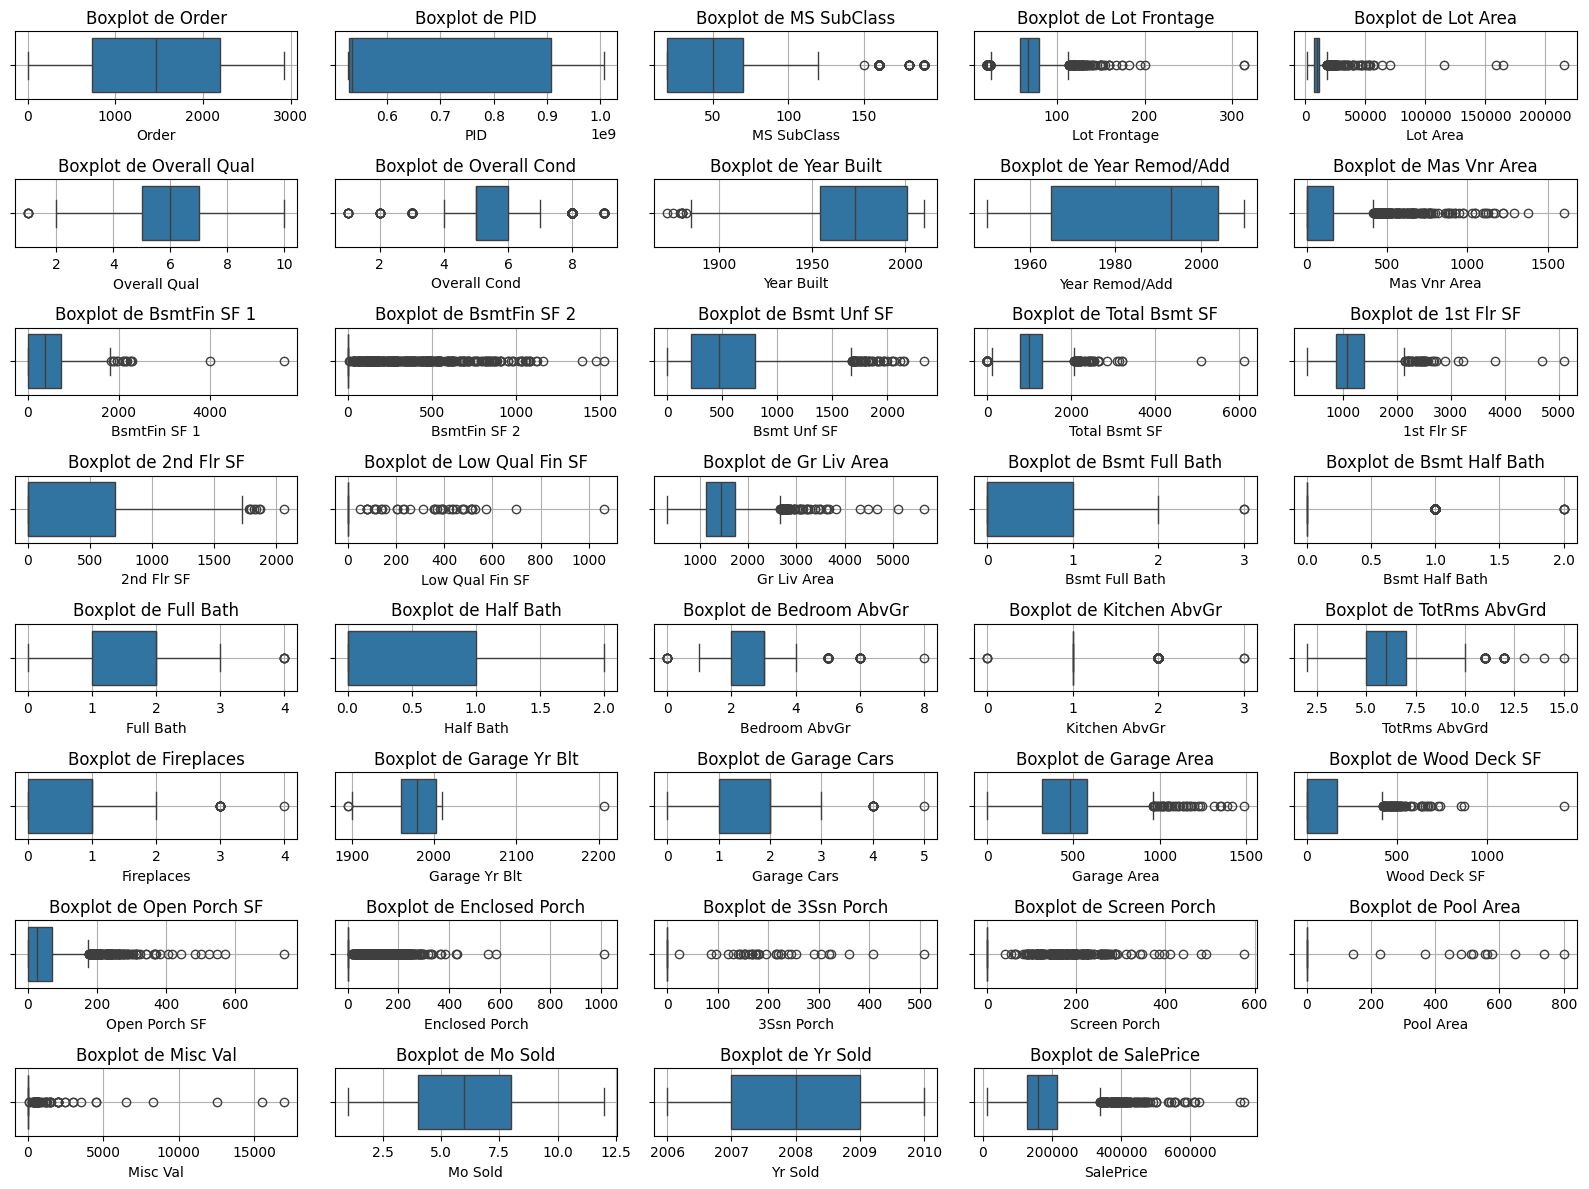

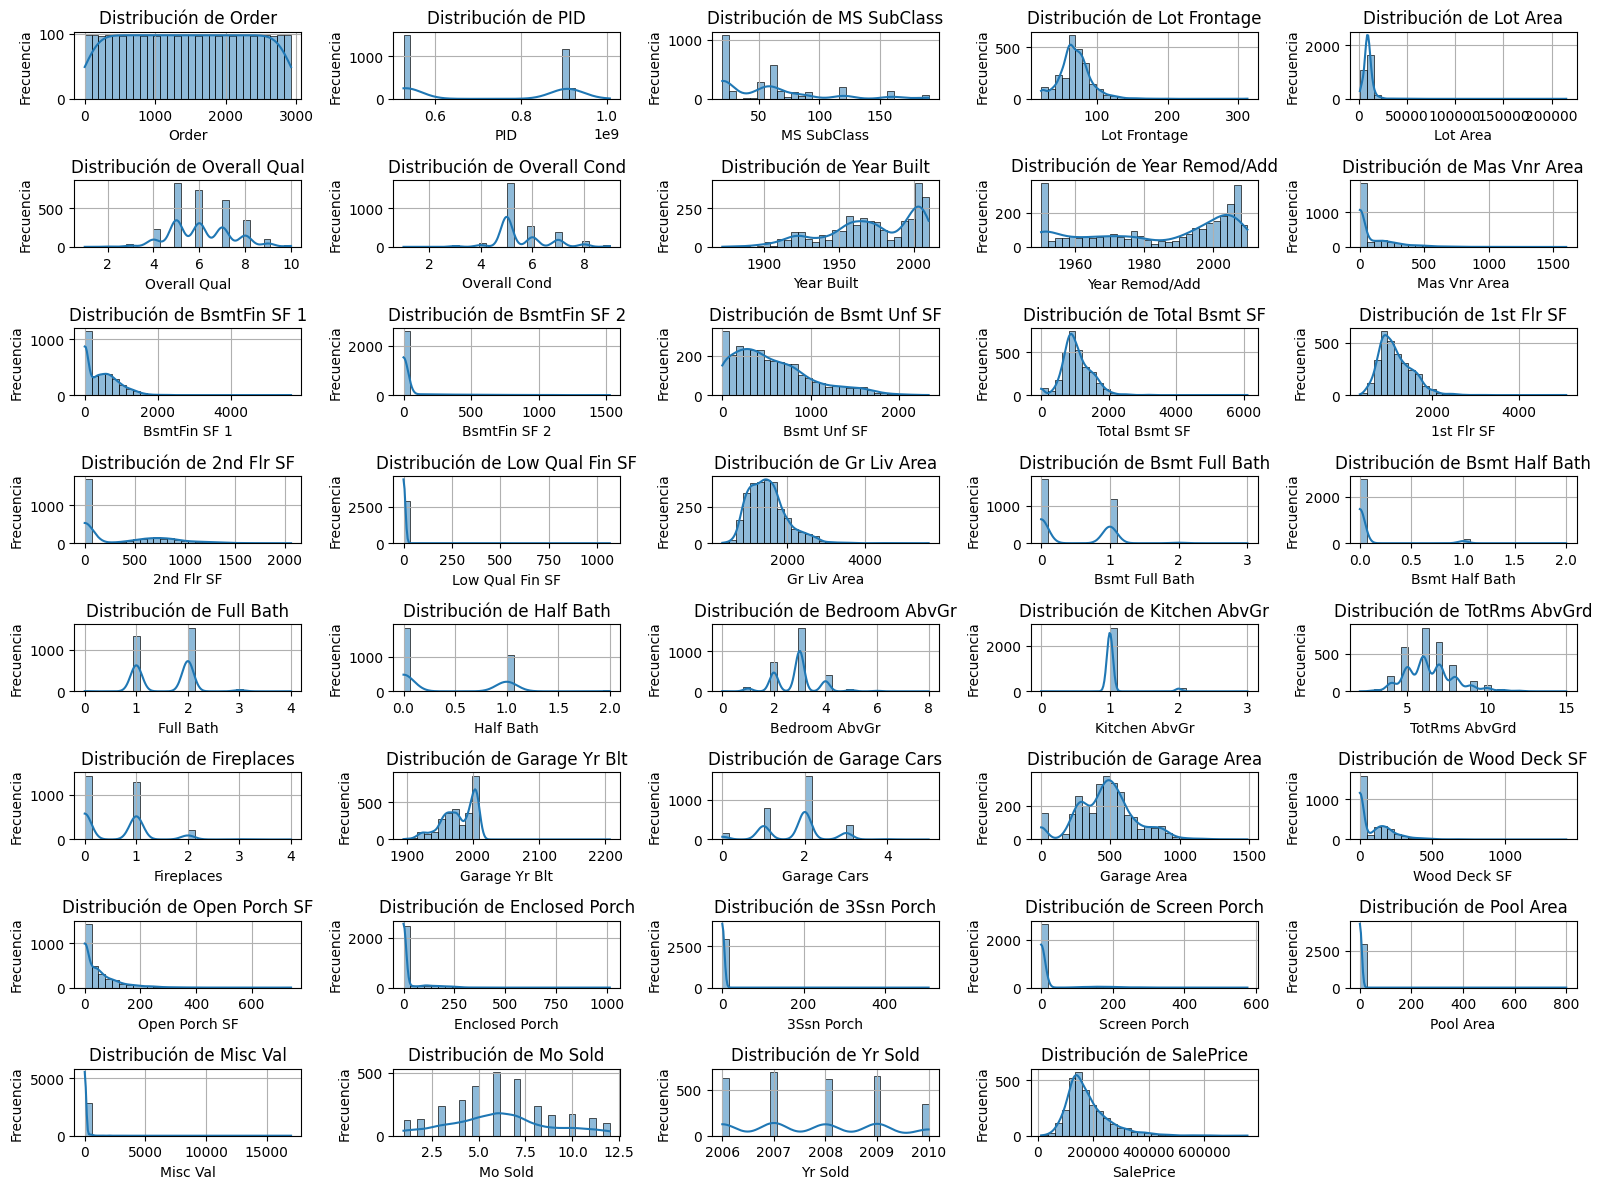

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# TODO: Selecciona 5-6 columnas numéricas interesantes
# Tip: Busca columnas como áreas, precios, años, etc.
df_raw = pd.read_csv('AmesHousing.csv')
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()


# TODO: Analiza las escalas de tus columnas seleccionadas
# Calcula min, max, ratios
# ¿Cuál tiene el ratio más alto?
scale_analysis = {}
for col in numeric_cols:
    col_min = df_raw[col].min()
    col_max = df_raw[col].max()
    ratio = col_max / col_min if col_min != 0 else np.inf
    scale_analysis[col] = {
        'min': col_min,
        'max': col_max,
        'ratio': ratio
    }
scale_df = pd.DataFrame(scale_analysis).T
print("\n📈 Análisis de escalas de las columnas seleccionadas:")
print(scale_df)

# TODO: Crea visualizaciones para mostrar el problema
# Histogramas, boxplots, o lo que consideres mejor
# Guarda tus gráficos en la carpeta 'results/'
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(8, len(numeric_cols)//8 + 1, i+1) 
    sns.boxplot(x=df_raw[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.grid(True)
plt.tight_layout()  
save_visualization(plt.gcf(), 'boxplot_numericas', 'Boxplot de columnas numéricas') 
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(8, len(numeric_cols)//8 + 1, i+1) 
    sns.histplot(df_raw[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
plt.tight_layout()
save_visualization(plt.gcf(), 'distribucion_numericas', 'Distribución de columnas numéricas')

# TODO: Documenta tus hallazgos
print("📊 MIS HALLAZGOS:")
print("Columna más problemática:")
print(scale_df.sort_values(by='ratio', ascending=False).head(1))
print("Ratio más alto:")
print(scale_df['ratio'].max())
print("¿Por qué es problemático?: Porque puede sesgar modelos basados en distancia como KNN y SVM.")

💾 [09:10:06] Visualización guardada: visual_6bonus/boxplot_numericas_bonus.png
📝 Descripción: Boxplot de columnas numéricas
💾 [09:10:50] Visualización guardada: visual_6bonus/distribucion_numericas_bonus.png
📝 Descripción: Distribución de columnas numéricas


'visual_6bonus/distribucion_numericas_bonus.png'

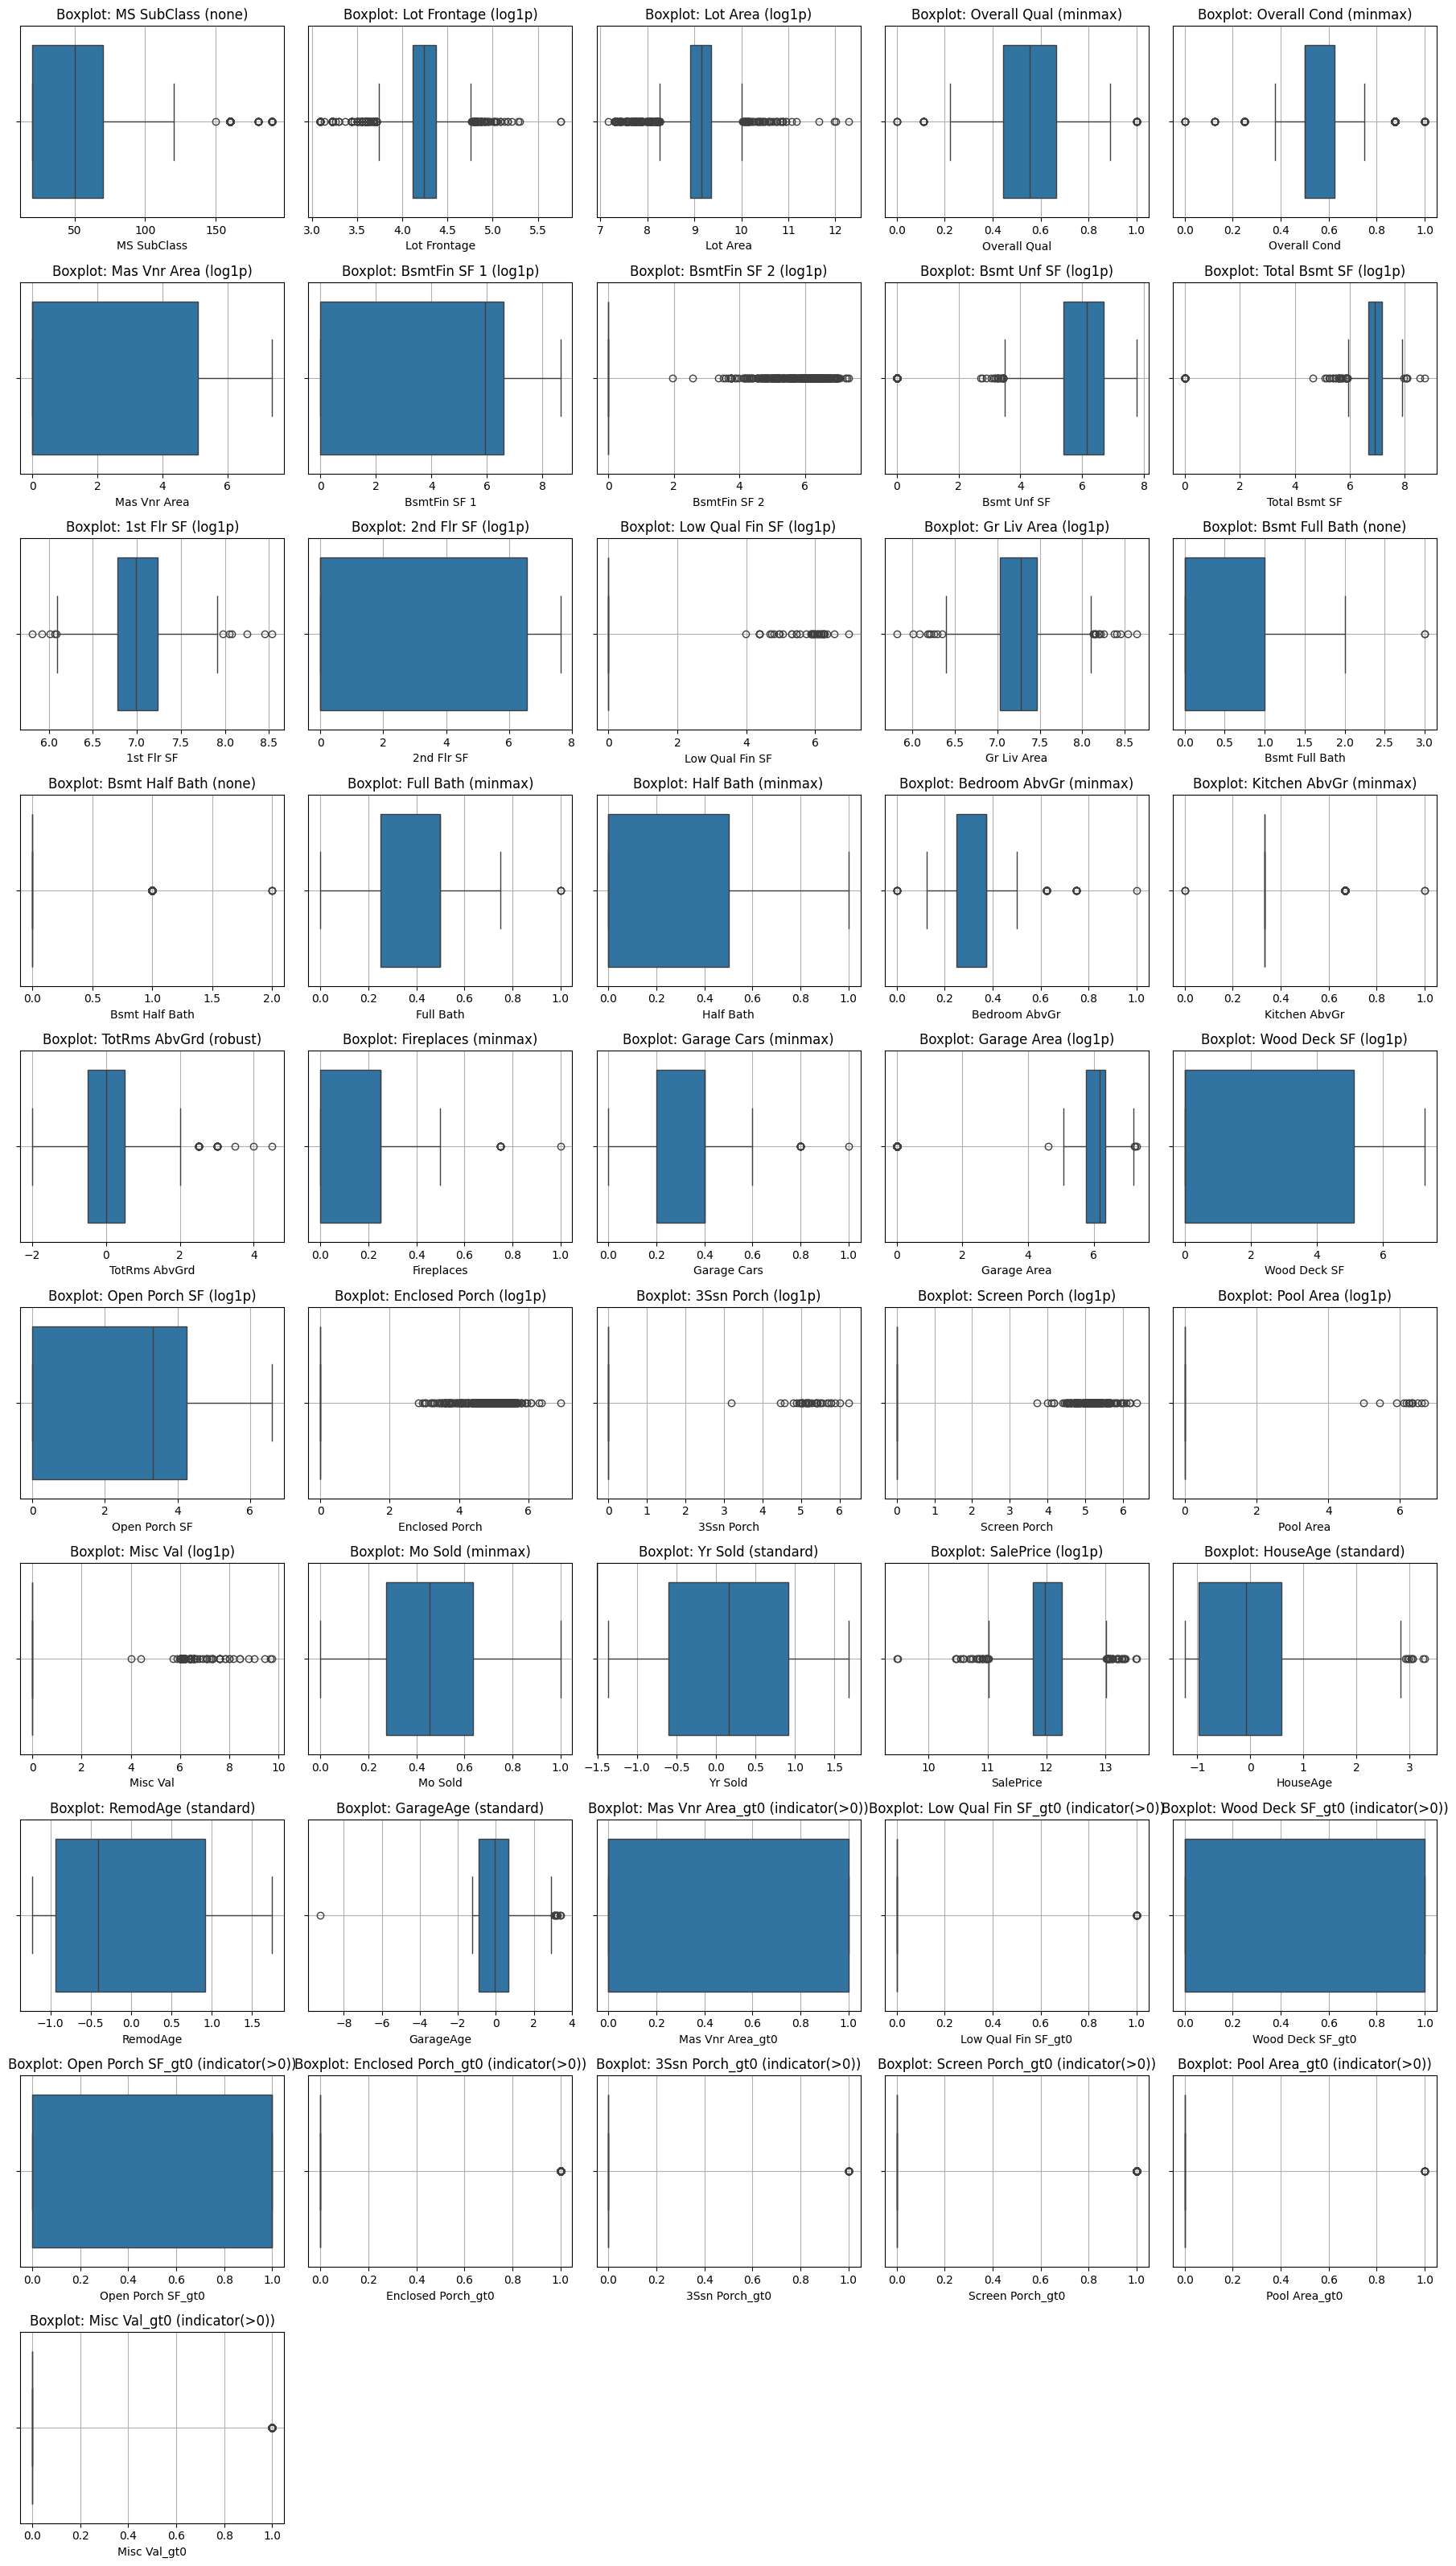

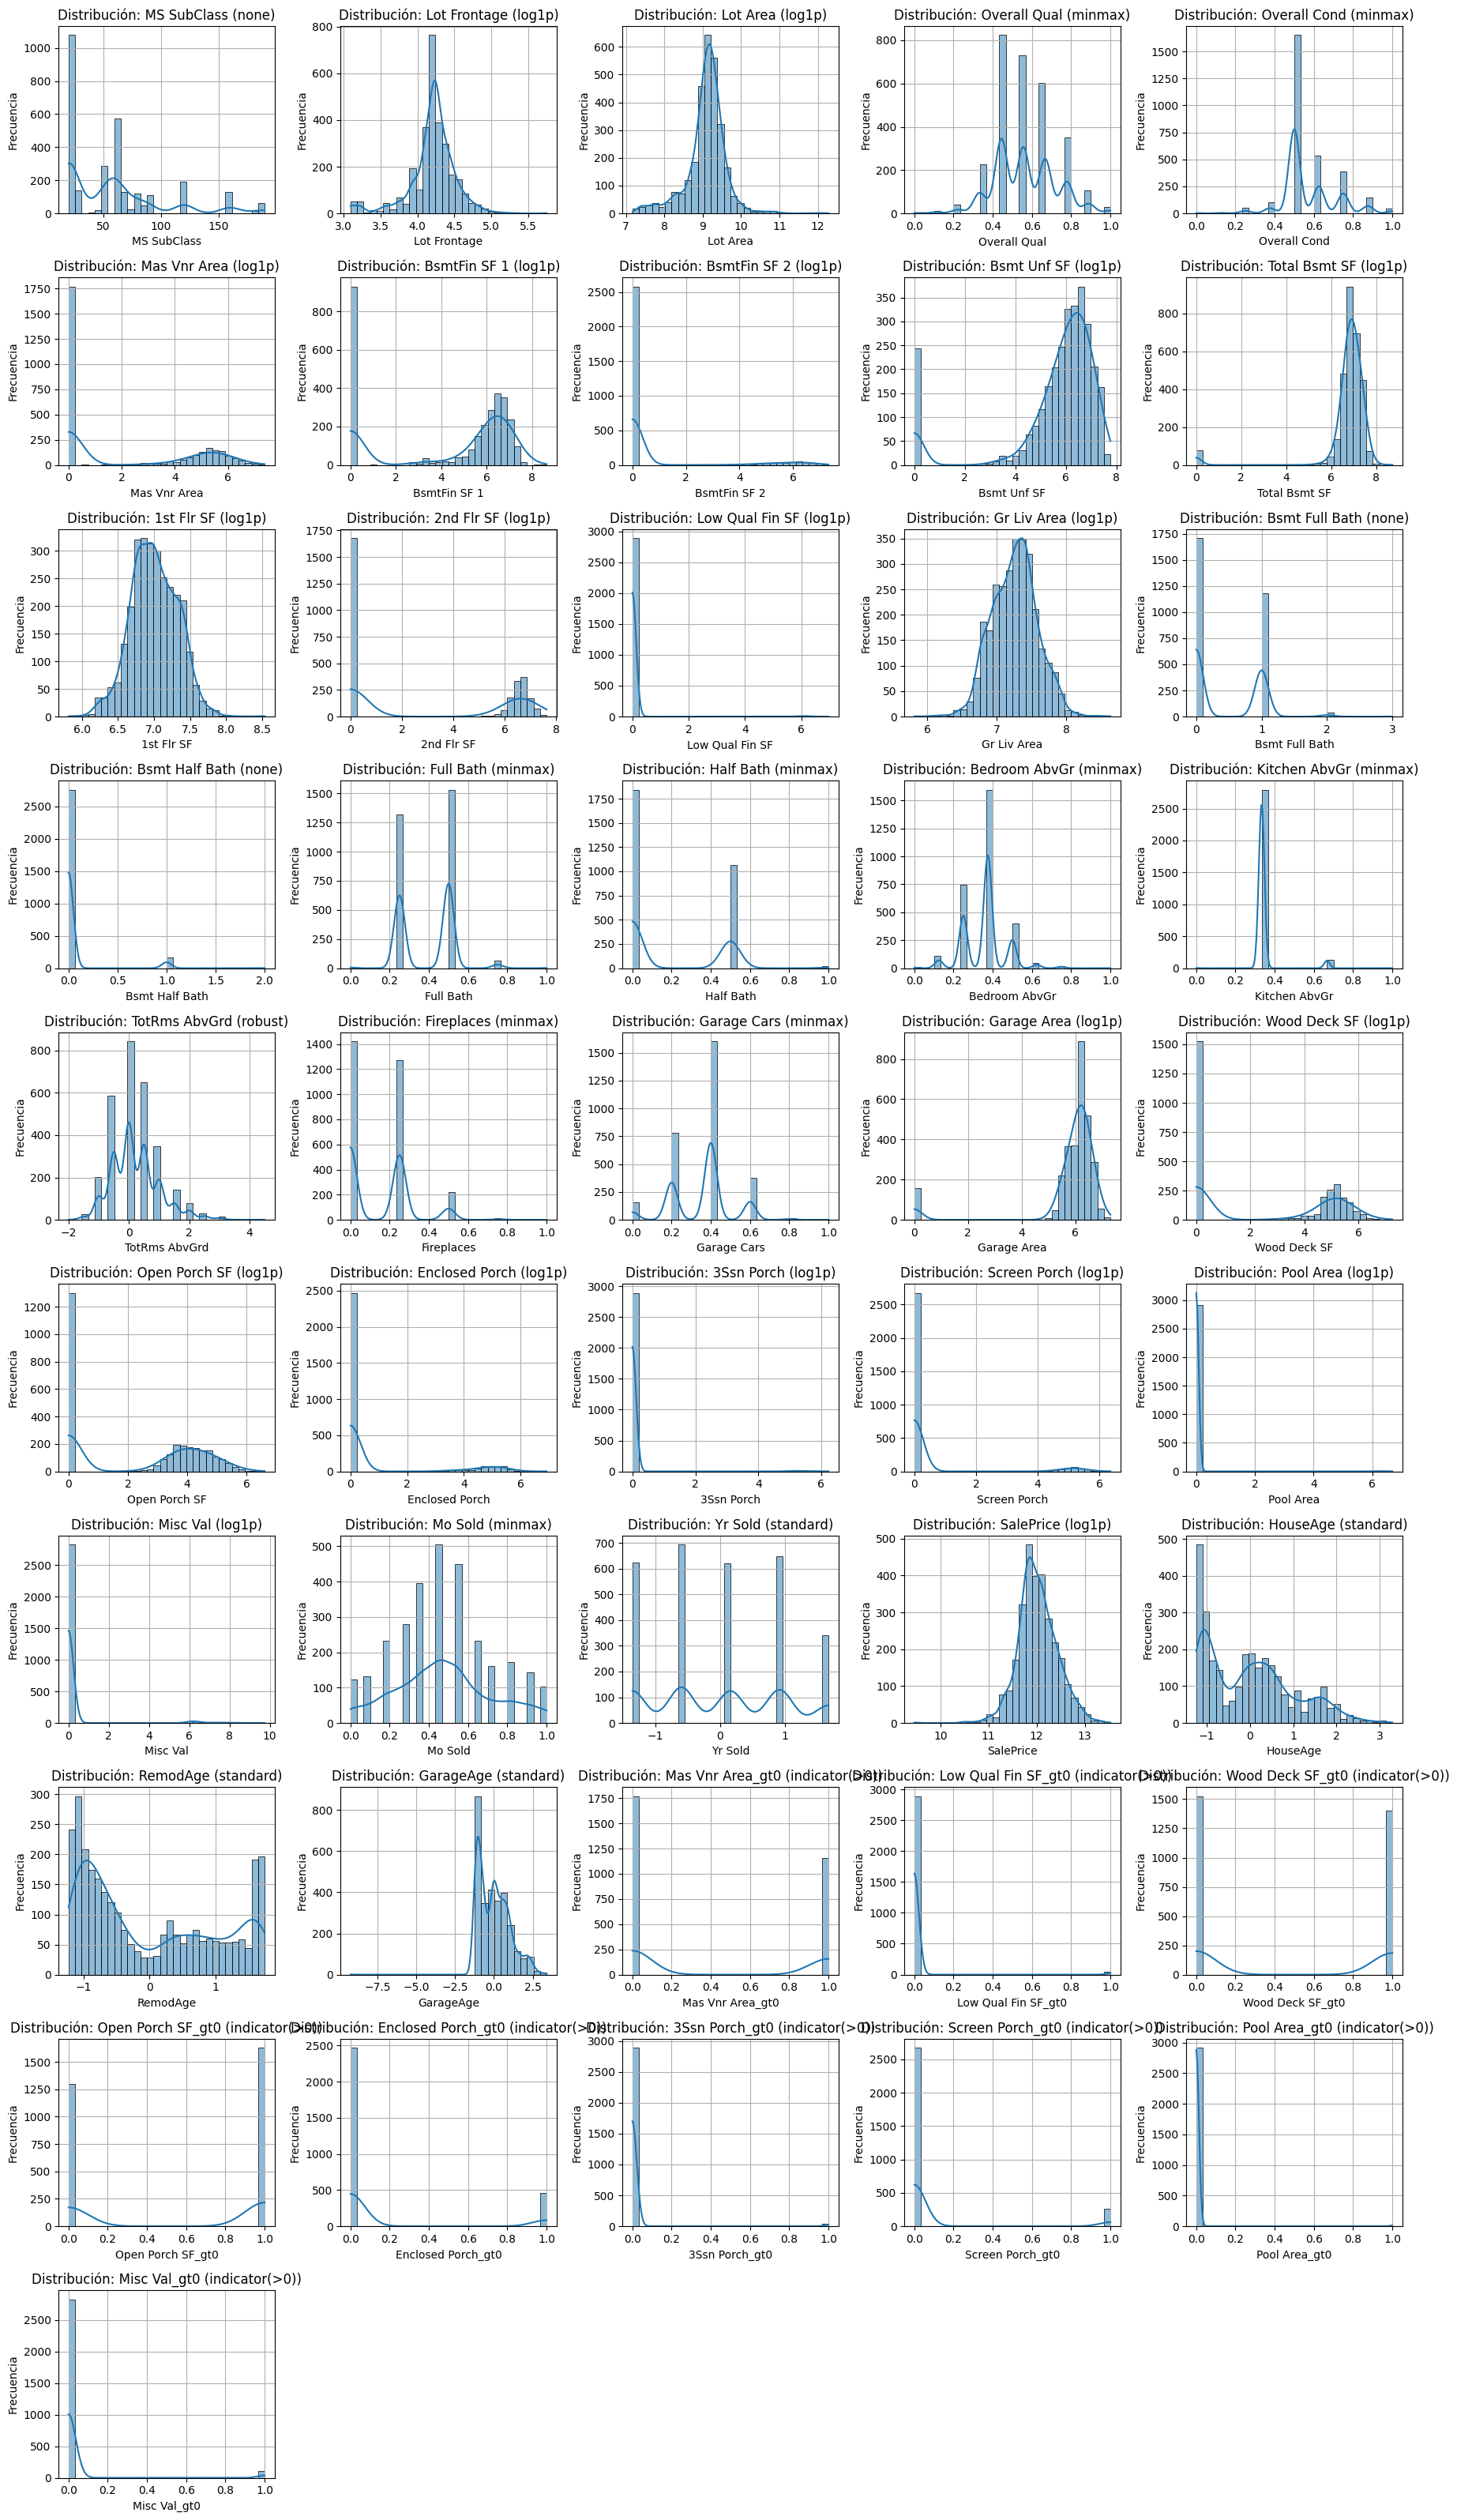

In [8]:
# Aplicamos los transformadores correspondientes a las distintas graficas y reevaluamos
drop_cols = ['Order', 'PID']
log1p_cols = [
    'Lot Area','Lot Frontage','Mas Vnr Area',
    'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
    '1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
    'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch',
    '3Ssn Porch','Screen Porch','Pool Area','Misc Val',
    'SalePrice'
]
zero_inflated_cols = [
    'Mas Vnr Area','Low Qual Fin SF','Wood Deck SF','Open Porch SF',
    'Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val'
]
robust_cols = ['TotRms AbvGrd']
year_cols = ['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold']
ordinal_small_cols = [
    'Overall Qual','Overall Cond','Full Bath','Half Bath',
    'Bedroom AbvGr','Kitchen AbvGr','Fireplaces','Garage Cars','Mo Sold'
]

def normalize_numeric_only(df_raw: pd.DataFrame):
    # 0) quedarme solo con numéricas
    numeric_cols = df_raw.select_dtypes(include='number').columns.tolist()
    df = df_raw[numeric_cols].copy()

    # 1) dropear IDs si están
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

    # 2) intersecciones (solo numéricas presentes)
    log1p_use   = [c for c in log1p_cols if c in df.columns]
    zeroinf_use = [c for c in zero_inflated_cols if c in df.columns]
    robust_use  = [c for c in robust_cols if c in df.columns]
    years_use   = [c for c in year_cols if c in df.columns]
    ordinal_use = [c for c in ordinal_small_cols if c in df.columns]

    # 3) ingeniería de años → edades (si existen todas las necesarias)
    if set(['Yr Sold']).issubset(df.columns):
        if 'Year Built' in df.columns:
            df['HouseAge'] = df['Yr Sold'] - df['Year Built']
        if 'Year Remod/Add' in df.columns:
            df['RemodAge'] = df['Yr Sold'] - df['Year Remod/Add']
        if 'Garage Yr Blt' in df.columns:
            df['GarageAge'] = df['Yr Sold'] - df['Garage Yr Blt']
        # opcional: quitar crudos (menos Yr Sold)
        df.drop(columns=[c for c in ['Year Built','Year Remod/Add','Garage Yr Blt'] if c in df.columns],
                inplace=True, errors='ignore')

    # 4) indicadores para cero-infladas
    for c in zeroinf_use:
        df[f'{c}_gt0'] = (df[c] > 0).astype(int)

    # 5) imputación simple por mediana
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].fillna(df[c].median())

    # 6) log1p en seleccionadas
    for c in log1p_use:
        df[c] = np.log1p(np.clip(df[c].astype(float), 0, None))

    # 7) escalados
    if robust_use:
        df[robust_use] = RobustScaler().fit_transform(df[robust_use])

    std_cols = [c for c in ['HouseAge','RemodAge','GarageAge','Yr Sold'] if c in df.columns]
    if std_cols:
        df[std_cols] = StandardScaler().fit_transform(df[std_cols])

    if ordinal_use:
        df[ordinal_use] = MinMaxScaler().fit_transform(df[ordinal_use])

    # 8) mapping de qué se aplicó (útil para reporte)
    applied = {}
    for c in df.columns:
        if c in log1p_use:
            applied[c] = 'log1p'
        elif c in robust_use:
            applied[c] = 'robust'
        elif c in std_cols:
            applied[c] = 'standard'
        elif c in ordinal_use:
            applied[c] = 'minmax'
        elif c.endswith('_gt0'):
            applied[c] = 'indicator(>0)'
        else:
            applied[c] = 'none'

    return df, applied


df_num_ready, transform_map = normalize_numeric_only(df_raw)


# columnas numéricas nuevas
import math
numeric_new = df_num_ready.select_dtypes(include='number').columns.tolist()

def plot_grid(df, cols, kind='box', max_cols=5, figsize=(18, 3.2), title_note_map=None):
    """
    kind: 'box' o 'hist'
    title_note_map: dict opcional {col: 'log1p'|'robust'|...} para agregar al título
    """
    n = len(cols)
    ncols = min(max_cols, max(1, n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    axes = np.atleast_1d(axes).ravel()

    # desactivar ejes sobrantes
    for ax in axes[n:]:
        ax.set_visible(False)

    for ax, c in zip(axes[:n], cols):
        note = f" ({title_note_map[c]})" if title_note_map and c in title_note_map else ""
        if kind == 'box':
            sns.boxplot(x=df[c], ax=ax)
            ax.set_title(f"Boxplot: {c}{note}")
            ax.set_xlabel(c)
        elif kind == 'hist':
            sns.histplot(df[c], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución: {c}{note}")
            ax.set_xlabel(c)
            ax.set_ylabel("Frecuencia")
        ax.grid(True)

    fig.tight_layout()
    return fig

# graficos
_ = plot_grid(df_num_ready, numeric_new, kind='box',  max_cols=5, title_note_map=transform_map)
save_visualization(plt.gcf(), 'boxplot_numericas_bonus', 'Boxplot de columnas numéricas')
_ = plot_grid(df_num_ready, numeric_new, kind='hist', max_cols=5, title_note_map=transform_map)
save_visualization(plt.gcf(), 'distribucion_numericas_bonus', 'Distribución de columnas numéricas')


# 📑 Reporte de Transformaciones Numéricas

| Variable                | Transformación | Notas / Justificación |
|--------------------------|----------------|------------------------|
| **Order**               | Drop           | ID / índice, sin valor analítico |
| **PID**                 | Drop           | Identificador único |
| **MS SubClass**         | none / categ.  | Mejor tratar como categórica (clase de vivienda) |
| **Lot Frontage**        | log1p          | Positivos, cola larga, valores atípicos |
| **Lot Area**            | log1p          | Distribución muy sesgada a derecha |
| **Overall Qual**        | minmax         | Escala ordinal 1–10 |
| **Overall Cond**        | minmax         | Escala ordinal 1–9 |
| **Year Built**          | → HouseAge std | Convertido a edad (Yr Sold - Built), escalado estándar |
| **Year Remod/Add**      | → RemodAge std | Convertido a edad de remodelación, escalado estándar |
| **BsmtFin SF 1**        | log1p          | Sesgo fuerte, valores extremos |
| **BsmtFin SF 2**        | log1p          | Muchos ceros, sesgo a derecha |
| **Bsmt Unf SF**         | log1p          | Sesgo fuerte, gran dispersión |
| **Total Bsmt SF**       | log1p          | Colas largas, magnitudes muy grandes |
| **1st Flr SF**          | log1p          | Sesgo fuerte, outliers |
| **2nd Flr SF**          | log1p          | Sesgo fuerte, muchos ceros |
| **Low Qual Fin SF**     | log1p + gt0    | Cero-inflada, indicador + transformación |
| **Gr Liv Area**         | log1p          | Muy sesgada, valores grandes |
| **Bsmt Full Bath**      | none           | Valores pequeños enteros, discreta |
| **Bsmt Half Bath**      | none           | Muy pocos valores distintos, discreta |
| **Full Bath**           | minmax         | Ordinal con pocos valores enteros |
| **Half Bath**           | minmax         | Ordinal con pocos valores enteros |
| **Bedroom AbvGr**       | minmax         | Ordinal discreta |
| **Kitchen AbvGr**       | minmax         | Muy pocos valores distintos (casi constante) |
| **TotRms AbvGrd**       | robust         | Simétrica con outliers, robust scaler adecuado |
| **Fireplaces**          | minmax         | Discreta con rango pequeño |
| **Garage Yr Blt**       | → GarageAge std| Convertido a edad, estandarizado |
| **Garage Cars**         | minmax         | Discreta, 0–4 autos |
| **Garage Area**         | log1p          | Sesgada a derecha |
| **Wood Deck SF**        | log1p + gt0    | Cero-inflada |
| **Open Porch SF**       | log1p + gt0    | Cero-inflada |
| **Enclosed Porch**      | log1p + gt0    | Cero-inflada |
| **3Ssn Porch**          | log1p + gt0    | Cero-inflada |
| **Screen Porch**        | log1p + gt0    | Cero-inflada |
| **Pool Area**           | log1p + gt0    | Cero-inflada |
| **Misc Val**            | log1p + gt0    | Mayormente ceros, pocos valores grandes |
| **Mo Sold**             | minmax         | Mes (1–12), ordinal circular |
| **Yr Sold**             | standard       | Año de venta, centrado y escalado |
| **SalePrice (target)**  | log1p          | Muy sesgado, transformación clásica en Kaggle |

---

📌 **Indicadores `*_gt0`**: columnas adicionales que marcan la **presencia (>0)** en variables cero-infladas, para complementar el valor transformado.  

📌 **Años**: `Year Built`, `Year Remod/Add`, `Garage Yr Blt` se convirtieron en **edades relativas a `Yr Sold`**, lo que tiene más sentido analítico.  